# **SpaceX  Falcon 9 first stage Landing Prediction**

We will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. In this lab, you will collect and make sure the data is in the correct format from an API. The following is an example of a successful and launch.

## 1: Collecting the data

#### Objectives: We will make a get request to the SpaceX API and also do some basic data wrangling and formating. 

- Request to the SpaceX API
- Clean the requested data

## Import Libraries and Define Auxiliary Functions

In [157]:
import requests
import pandas as pd
import numpy as np
import datetime
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon
import wget
import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data.

From the <code>rocket</code> column we would like to learn the booster name.

In [3]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the <code>launchpad</code> we would like to know the name of the launch site being used, the logitude, and the latitude.

In [4]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to.

In [5]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

In [6]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Request rocket launch data from SpaceX API with the following URL:

In [8]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)

In [10]:
#print(response.content)

### Request and parse the SpaceX launch data using the GET request

To make the requested JSON results more consistent, we will use the following static response object for this project:

In [11]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

In [12]:
response.status_code

200

Now we decode the response content as a Json using <code>.json()</code> and turn it into a Pandas dataframe using <code>.json_normalize()</code>


In [13]:
# Use json_normalize method to convert the json result into a dataframe
data  = response.json()
df = pd.json_normalize(data)

In [15]:
df.head(1)

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN


We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns <code>rocket</code>, <code>payloads</code>, <code>launchpad</code>, and <code>cores</code>.

In [16]:
# Subset of our dataframe keeping only the features we want and the flight number, and date_utc.
df = df[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
df = df[df['cores'].map(len)==1]
df = df[df['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
df['cores'] = df['cores'].map(lambda x : x[0])
df['payloads'] = df['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
df['date'] = pd.to_datetime(df['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
df = df[df['date'] <= datetime.date(2020, 11, 13)]

* From the <code>rocket</code> we would like to learn the booster name

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

* From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.

In [17]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [18]:
# Call getBoosterVersion
getBoosterVersion(df)

In [19]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [20]:
# Call getLaunchSite
getLaunchSite(df)

In [22]:
# Call getPayloadData
getPayloadData(df)

In [26]:
# Call getCoreData
getCoreData(df)

We we combine the columns into a dictionary.

In [28]:
launch_dict = {'FlightNumber': list(df['flight_number']),
'Date': list(df['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [30]:
launch_df = pd.DataFrame(launch_dict)

In [31]:
launch_df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


### Filter the dataframe to only include `Falcon 9` launches

In [33]:
data_falcon9 = launch_df[launch_df['BoosterVersion'] == 'Falcon 9']
data_falcon9.shape

(90, 17)

In [34]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


## Data Wrangling

In [35]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

### Task 3: Dealing with Missing Values

In [39]:
# Mean value of PayloadMass column
mean_payload_mass = data_falcon9['PayloadMass'].mean()

# Replace the np.nan values with mean value
data_falcon9['PayloadMass'].fillna(mean_payload_mass, inplace=True)

In [40]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [42]:
data_falcon9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

### Calculate the number of launches on each site

The data contains several Space X  launch facilities: <a href='https://en.wikipedia.org/wiki/List_of_Cape_Canaveral_and_Merritt_Island_launch_sites'>Cape Canaveral Space</a> Launch Complex 40  <b>VAFB SLC 4E </b> , Vandenberg Air Force Base Space Launch Complex 4E <b>(SLC-4E)</b>, Kennedy Space Center Launch Complex 39A <b>KSC LC 39A </b>.The location of each Launch Is placed in the column <code>LaunchSite</code>

In [43]:
data_falcon9['LaunchSite'].value_counts()

LaunchSite
CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64

* <b>LEO</b>: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth),[1] or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25.[2] Most of the manmade objects in outer space are in LEO.

* <b>VLEO</b>: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation.


* <b>GTO</b> A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 22,236 miles (35,786 kilometers) above Earth's equator, this position is a valuable spot for monitoring weather, communications and surveillance. Because the satellite orbits at the same speed that the Earth is turning, the satellite seems to stay in place over a single longitude, though it may drift north to south,” NASA wrote on its Earth Observatory website.


* <b>SSO (or SO)</b>: It is a Sun-synchronous orbit  also called a heliosynchronous orbit is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time.
    
    
    
* <b>ES-L1 </b>:At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the sun and the earth.
    
    
* <b>HEO</b> A highly elliptical orbit, is an elliptic orbit with high eccentricity, usually referring to one around Earth.


* <b> ISS </b> A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada).


* <b> MEO </b> Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit. These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours.


* <b> HEO </b> Geocentric orbits above the altitude of geosynchronous orbit (35,786 km or 22,236 mi).


* <b> GEO </b> It is a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation. 


* <b> PO </b> It is one type of satellites in which a satellite passes above or nearly above both poles of the body being orbited (usually a planet such as the Earth.



### Calculate the number and occurrence of each orbit

In [44]:
data_falcon9['Orbit'].value_counts()

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: count, dtype: int64

### Calculate the number and occurence of mission outcome of the orbits

In [45]:
landing_outcomes = data_falcon9['Outcome'].value_counts()
landing_outcomes

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

<code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.

In [46]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


Set of outcomes where the second stage did not land successfully:

In [48]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

### Landing outcome label from Outcome column

Using the <code>Outcome</code>,  create a list where the element is zero if the corresponding  row  in  <code>Outcome</code> is in the set <code>bad_outcome</code>; otherwise, it's one. Then assign it to the variable <code>landing_class</code>:

In [50]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in data_falcon9['Outcome']]
landing_class[:10]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]

This variable will represent the classification variable that represents the outcome of each launch. If the value is zero, the  first stage did not land successfully; one means  the first stage landed Successfully 

In [51]:
data_falcon9['Class']=landing_class
data_falcon9[['Class']].head(8)

,Class
4,0
5,0
6,0
7,0
8,0
9,0
10,1
11,1


In [52]:
data_falcon9["Class"].mean()

0.6666666666666666

### Visualize the relationship between Flight Number and Launch Site

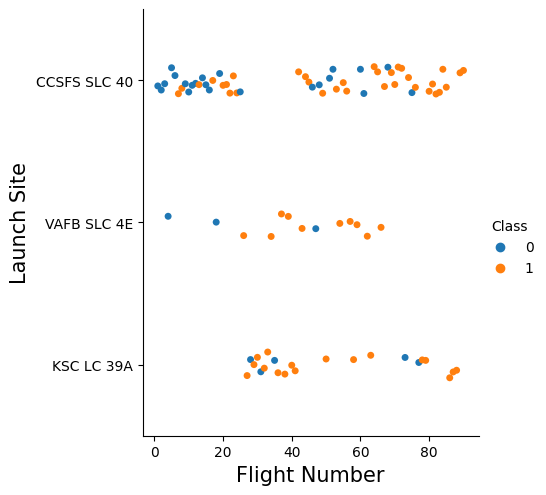

In [53]:
import seaborn as sns
from matplotlib import pyplot as plt


sns.catplot(y="LaunchSite",x="FlightNumber",hue="Class", data=data_falcon9, aspect = 1)
plt.ylabel("Launch Site",fontsize=15)
plt.xlabel("Flight Number",fontsize=15)

plt.show()

let's try to see how the `FlightNumber` (indicating the continuous launch attempts.) and `Payload` variables would affect the launch outcome.

We can plot out the <code>FlightNumber</code> vs. <code>PayloadMass</code>and overlay the outcome of the launch. We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass is also important; it seems the more massive the payload, the less likely the first stage will return.

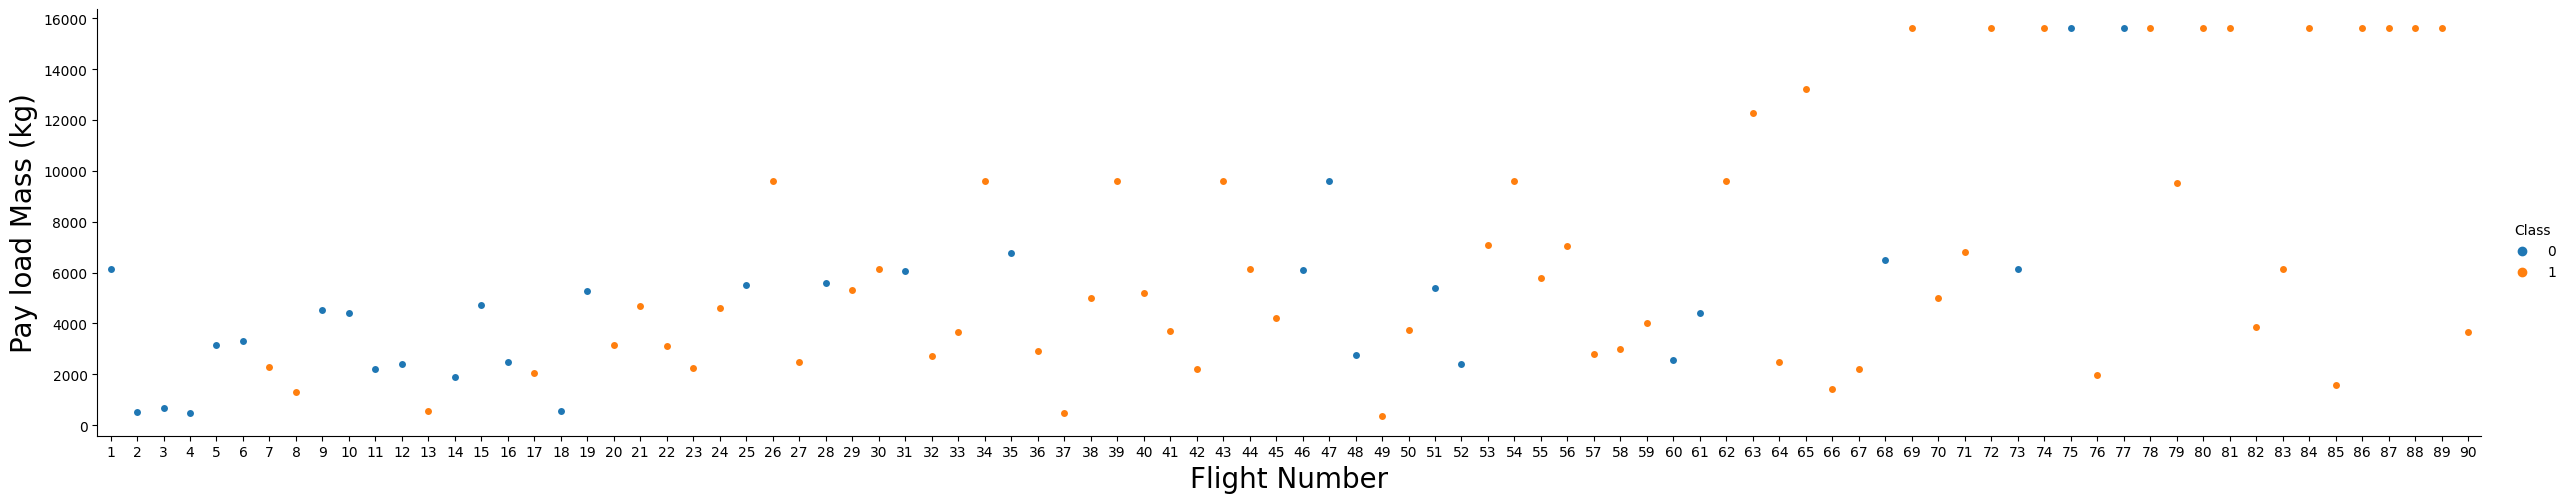

In [54]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

###  Visualize the relationship between Payload and Launch Site

We also want to observe if there is any relationship between launch sites and their payload mass.

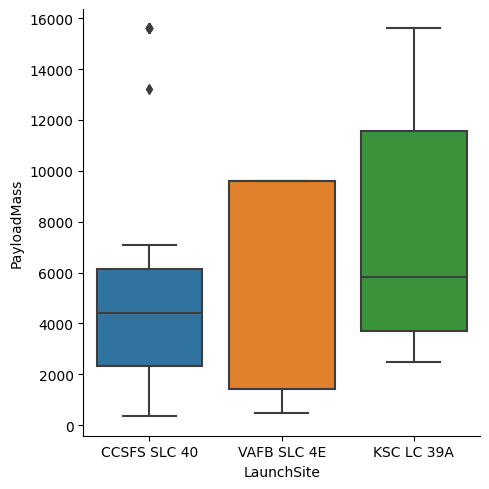

In [55]:
sns.catplot(x="LaunchSite", y="PayloadMass", data=data_falcon9, kind="box")

plt.show()

From the Payload Vs. Launch Site scatter point chart, we can see that at launch site: VAFB-SLC, there are no  rockets launched for mass greater than 10000.

### Visualize the relationship between success rate of each orbit type

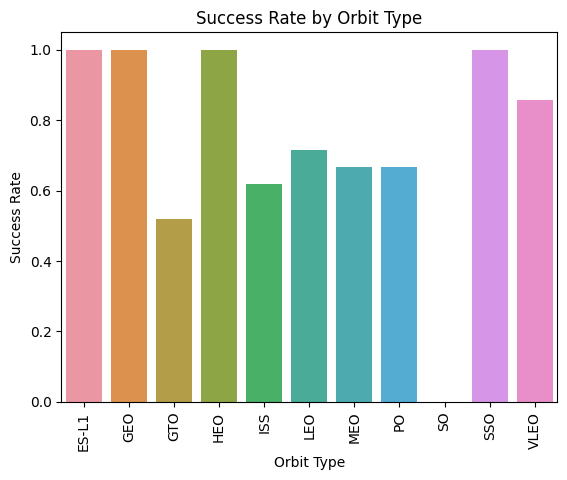

In [57]:
success_rate = data_falcon9.groupby('Orbit')['Class'].mean().reset_index()


sns.barplot(x="Orbit", y="Class", data=success_rate)

plt.xlabel('Orbit Type')
plt.ylabel('Success Rate')
plt.title('Success Rate by Orbit Type')

plt.xticks(rotation=90) 
plt.show()

###  Visualize the relationship between FlightNumber and Orbit type

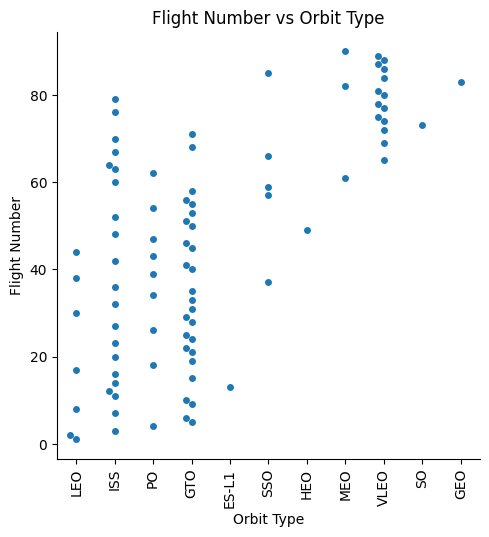

In [58]:
sns.catplot(x="Orbit", y="FlightNumber", data=data_falcon9, kind="swarm")

plt.xlabel('Orbit Type')
plt.ylabel('Flight Number')
plt.title('Flight Number vs Orbit Type')

plt.xticks(rotation=90)

plt.show()

### Visualize the relationship between Payload and Orbit type

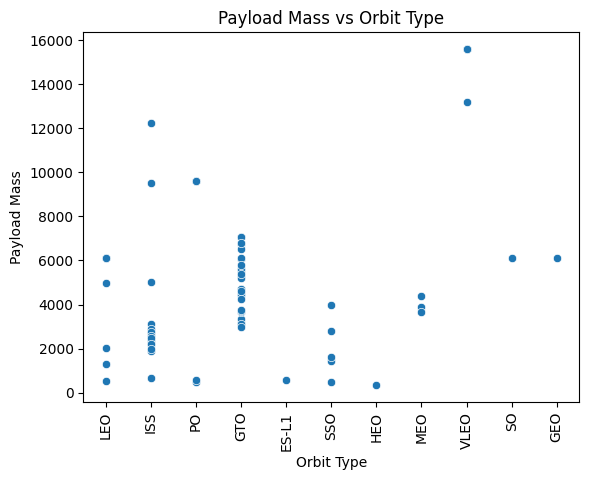

In [59]:
sns.scatterplot(x="Orbit", y="PayloadMass", data=data_falcon9)

plt.xlabel('Orbit Type')
plt.ylabel('Payload Mass')
plt.title('Payload Mass vs Orbit Type')

plt.xticks(rotation=90)

plt.show()

With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS.   

However for GTO we cannot distinguish this well as both positive landing rate and negative landing(unsuccessful mission) are both there here.

### Visualize the launch success yearly trend

In [65]:
def Extract_year(data_falcon9):
    return data_falcon9["Date"].apply(lambda x: x.year)

# Apply the function to add the year column to the dataframe
data_falcon9['Year'] = Extract_year(data_falcon9)

# Group by 'Year' and calculate the average success rate
success_rate_per_year = data_falcon9.groupby('Year')['Class'].mean().reset_index()


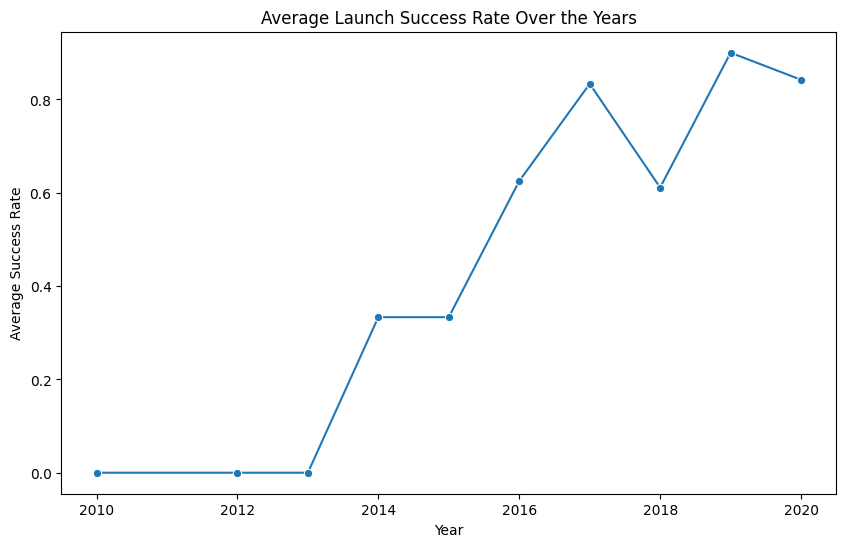

In [66]:
plt.figure(figsize=(10,6))
sns.lineplot(x="Year", y="Class", data=success_rate_per_year, marker='o')

plt.xlabel('Year')
plt.ylabel('Average Success Rate')
plt.title('Average Launch Success Rate Over the Years')

plt.show()

## Features Engineering 

We will select the features that will be used in success prediction in the future module.


In [143]:
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


 ### Create dummy variables to categorical columns

In [144]:
columns_to_encode = ['Orbit', 'LaunchSite', 'LandingPad', 'Serial']
features_one_hot = pd.get_dummies(features, columns=columns_to_encode)  

In [145]:
if 'Date' in features_one_hot.columns and 'BoosterVersion' in features_one_hot.columns:
    features_one_hot.drop(columns=['Date', 'BoosterVersion'], inplace=True)

### Convert numeric and boolean columns to float64

In [146]:
features_one_hot_numeric_bool = features_one_hot.select_dtypes(include=['number', 'bool'])
features_one_hot[features_one_hot_numeric_bool.columns] = features_one_hot_numeric_bool.astype('int')


### Cast all numeric columns to `float64`

In [148]:
features_one_hot = features_one_hot.astype('float64')
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1.0,6123.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,525.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,677.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,500.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.0,3170.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that our <code>features_one_hot</code> dataframe only contains numbers cast the entire dataframe to variable type <code>float64</code>

# **Launch Sites Locations Analysis with Folium**

The following dataset with the name `spacex_launch_geo.csv` is an augmented dataset with latitude and longitude added for each site. 

In [90]:
spacex_df=pd.read_csv('/Users/adamrivardwalter/Desktop/SpaceX Project/spacex_launch_geo.csv')

In [76]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


We first need to create a folium `Map` object, with an initial center location to be NASA Johnson Space Center at Houston, Texas as reference.

In [78]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

We will use `folium.Circle` to add a highlighted circle area with a text label on a specific coordinate. For example, 


In [79]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

Now we'll add a circle for each launch site in data frame `launch_sites`

In [80]:
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label

for index, site in launch_sites_df.iterrows():
    coordinate = [site['Lat'], site['Long']]
    launch_site_name = site['Launch Site']
    
    folium.Circle(
        coordinate, 
        radius=1000, 
        color='#000000', 
        fill=True
    ).add_child(folium.Popup(launch_site_name)).add_to(site_map)
    
    folium.Marker(
        coordinate,
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % launch_site_name,
        )
    ).add_to(site_map)

site_map

# Mark the success/failed launches for each site on the map

We'll try to enhance the map by adding the launch outcomes for each site, and see which sites have high success rates.

Note that a launch only happens in one of the four launch sites, which means many launch records will have the exact same coordinate. Marker clusters can be a good way to simplify a map containing many markers having the same coordinate.

In [81]:
marker_cluster = MarkerCluster()

In [82]:
# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


For each launch result in `spacex_df` data frame, add a `folium.Marker` to `marker_cluster`

In [83]:
site_map.add_child(marker_cluster)

# Loop through each row in spacex_df
for index, record in spacex_df.iterrows():
    coordinate = [record['Lat'], record['Long']]
    
    # Set the marker color based on the launch success or failure
    marker_color = record['marker_color']  

    marker = folium.Marker(
        location=coordinate,
        icon=folium.Icon(color='white', icon_color=marker_color),  # Customize icon with the marker color
        popup=f"Launch site: {record['Launch Site']} - {record['class']}"
    )

    marker_cluster.add_child(marker)

site_map

# **Space X  Falcon 9 First Stage Landing Prediction**

Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.

## Objectives
Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data

##  Define Functions

This function is to plot the confusion matrix.

In [86]:
def plot_confusion_matrix(y,y_predict):

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax);
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

We need to create a NumPy array from the column <code>Class</code> in <code>data_falcon9</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).

In [96]:
data_falcon9.head(0)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class,Year


In [97]:
Y = data_falcon9['Class'].to_numpy()

Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.

In [149]:
X = features_one_hot

In [150]:
transform = preprocessing.StandardScaler()

X = transform.fit_transform(X)

In [151]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Optionally, print the shapes of the resulting datasets to confirm the split
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (72, 80)
X_test shape: (18, 80)
Y_train shape: (72,)
Y_test shape: (18,)


We will create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Let's try to fit the object to find the best parameters from the dictionary <code>parameters</code>.

In [152]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [153]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.

In [154]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


We can calculate the accuracy on the test data using the method <code>score</code>:

In [177]:
test_accuracy_logreg = logreg_cv.score(X_test, Y_test)

print(f"Accuracy on the test data: {test_accuracy:.4f}")

Accuracy on the test data: 0.8333


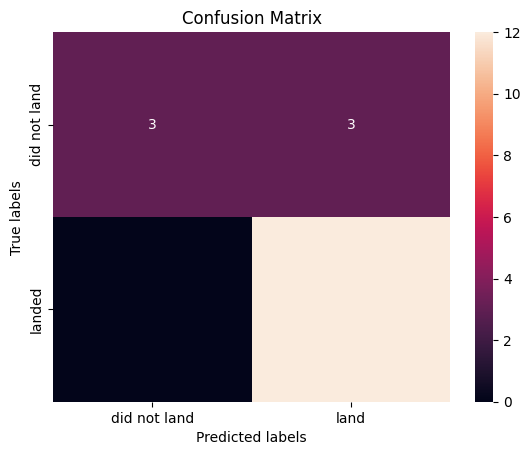

In [158]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.

Overview:

True Postive - 12 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)

Let's try a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.

In [159]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

svm_cv = GridSearchCV(svm, parameters, cv=10)

svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [160]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


The accuracy on the test data using the method <code>score</code>:

In [163]:
test_accuracy_svm = svm_cv.score(X_test, Y_test)
test_accuracy_svm

0.8333333333333334

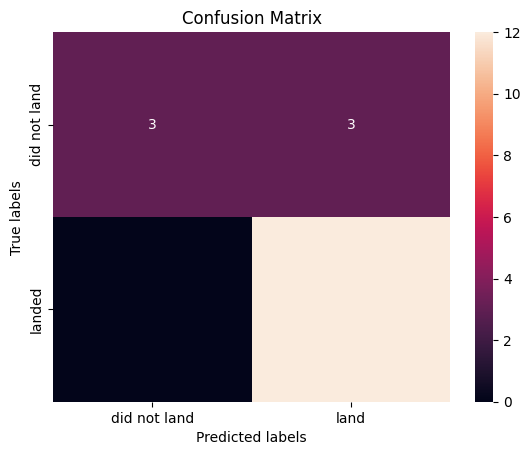

In [162]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Let's create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.

In [164]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree_cv = DecisionTreeClassifier()

In [165]:
tree_cv = GridSearchCV(tree_cv, parameters, cv=10)

tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [166]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
accuracy : 0.8607142857142858


Accuracy of tree_cv on the test data using the method <code>score</code>:

In [168]:
test_accuracy_tree = tree_cv.score(X_test, Y_test)
test_accuracy_tree

0.7777777777777778

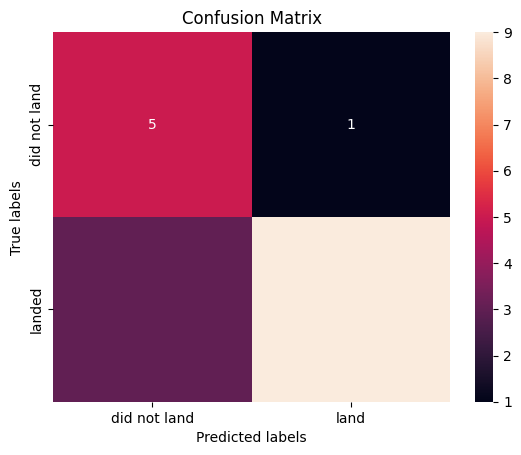

In [169]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Let's try making a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.

In [170]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

knn_cv = KNeighborsClassifier()

In [171]:
knn_cv = GridSearchCV(knn_cv, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [172]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8339285714285714


In [176]:
test_accuracy_knn = knn_cv.score(X_test, Y_test)
test_accuracy_knn

0.7777777777777778

Accuracy of knn_cv on the test data using the method <code>score</code>:

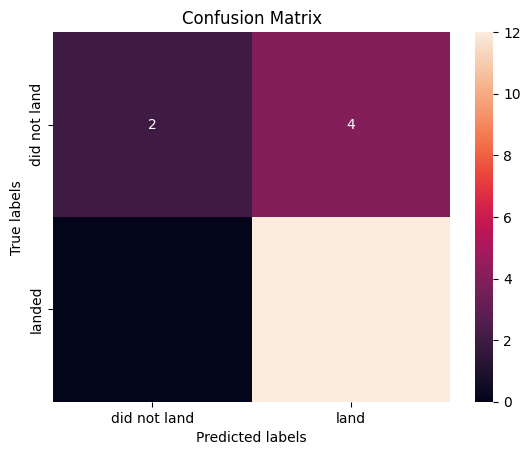

In [173]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Let's find the method performs best:

In [178]:
# Print all the test accuracies
print(f"Logistic Regression Test Accuracy: {test_accuracy_logreg:.4f}")
print(f"Support Vector Machine Test Accuracy: {test_accuracy_svm:.4f}")
print(f"Decision Tree Test Accuracy: {test_accuracy_tree:.4f}")
print(f"K-Nearest Neighbors Test Accuracy: {test_accuracy_knn:.4f}")

# Find the best model
best_model = max(
    [
        ("Logistic Regression", test_accuracy_logreg),
        ("Support Vector Machine", test_accuracy_svm),
        ("Decision Tree", test_accuracy_tree),
        ("K-Nearest Neighbors", test_accuracy_knn)
    ],
    key=lambda x: x[1]
)

print(f"\nThe best performing model is: {best_model[0]} with an accuracy of {best_model[1]:.4f}")

Logistic Regression Test Accuracy: 0.8333
Support Vector Machine Test Accuracy: 0.8333
Decision Tree Test Accuracy: 0.7778
K-Nearest Neighbors Test Accuracy: 0.7778

The best performing model is: Logistic Regression with an accuracy of 0.8333


We can see thatour scores for Logistic Regression & Support Vector Machine we tied for first. Clearly we need more than 90 rows of data for a better analysis